<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Wavelet_lead_lag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
pip install PyWavelets

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



Data Summary:
Date Range: 2014-11-17 to 2023-01-05
Number of observations: 2048

Computing wavelet lead-lag correlations...


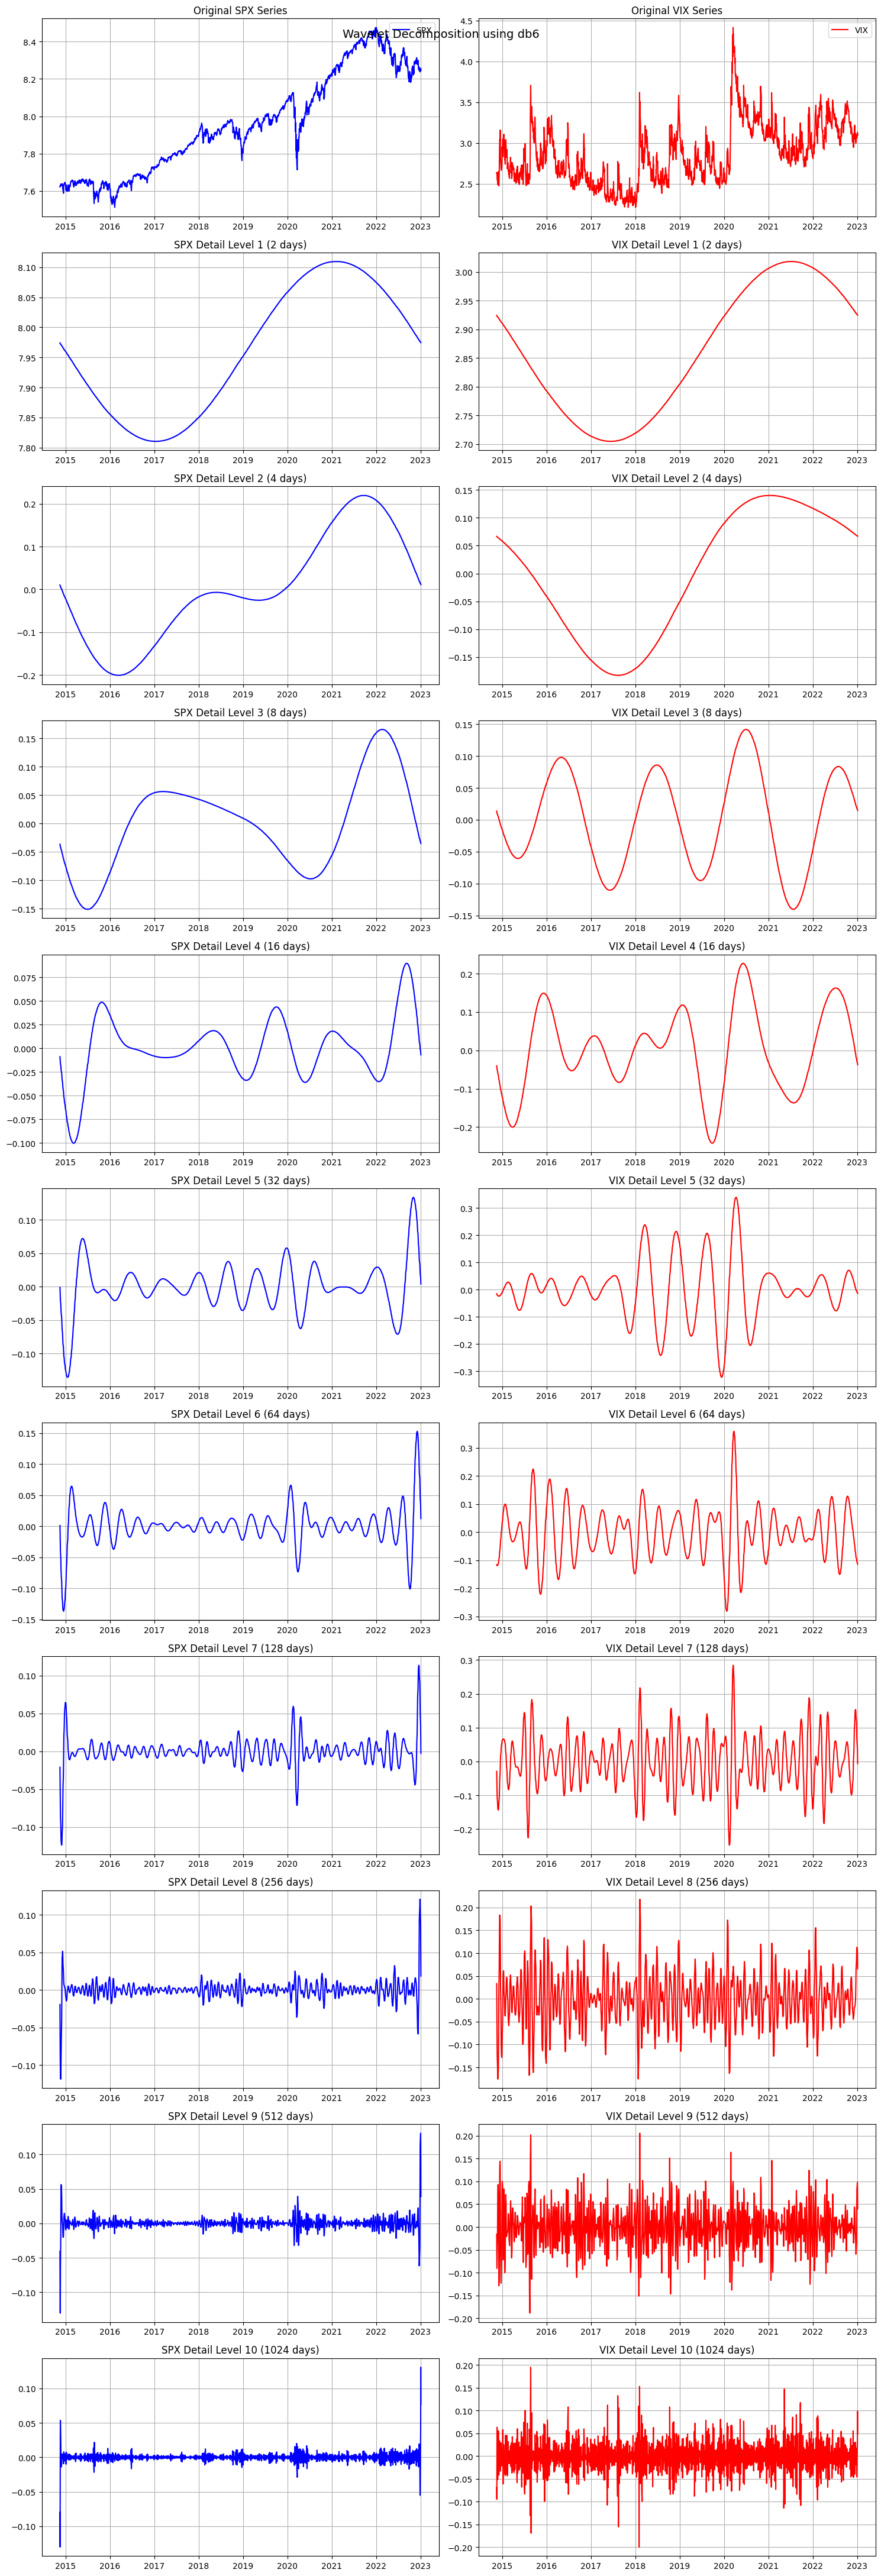

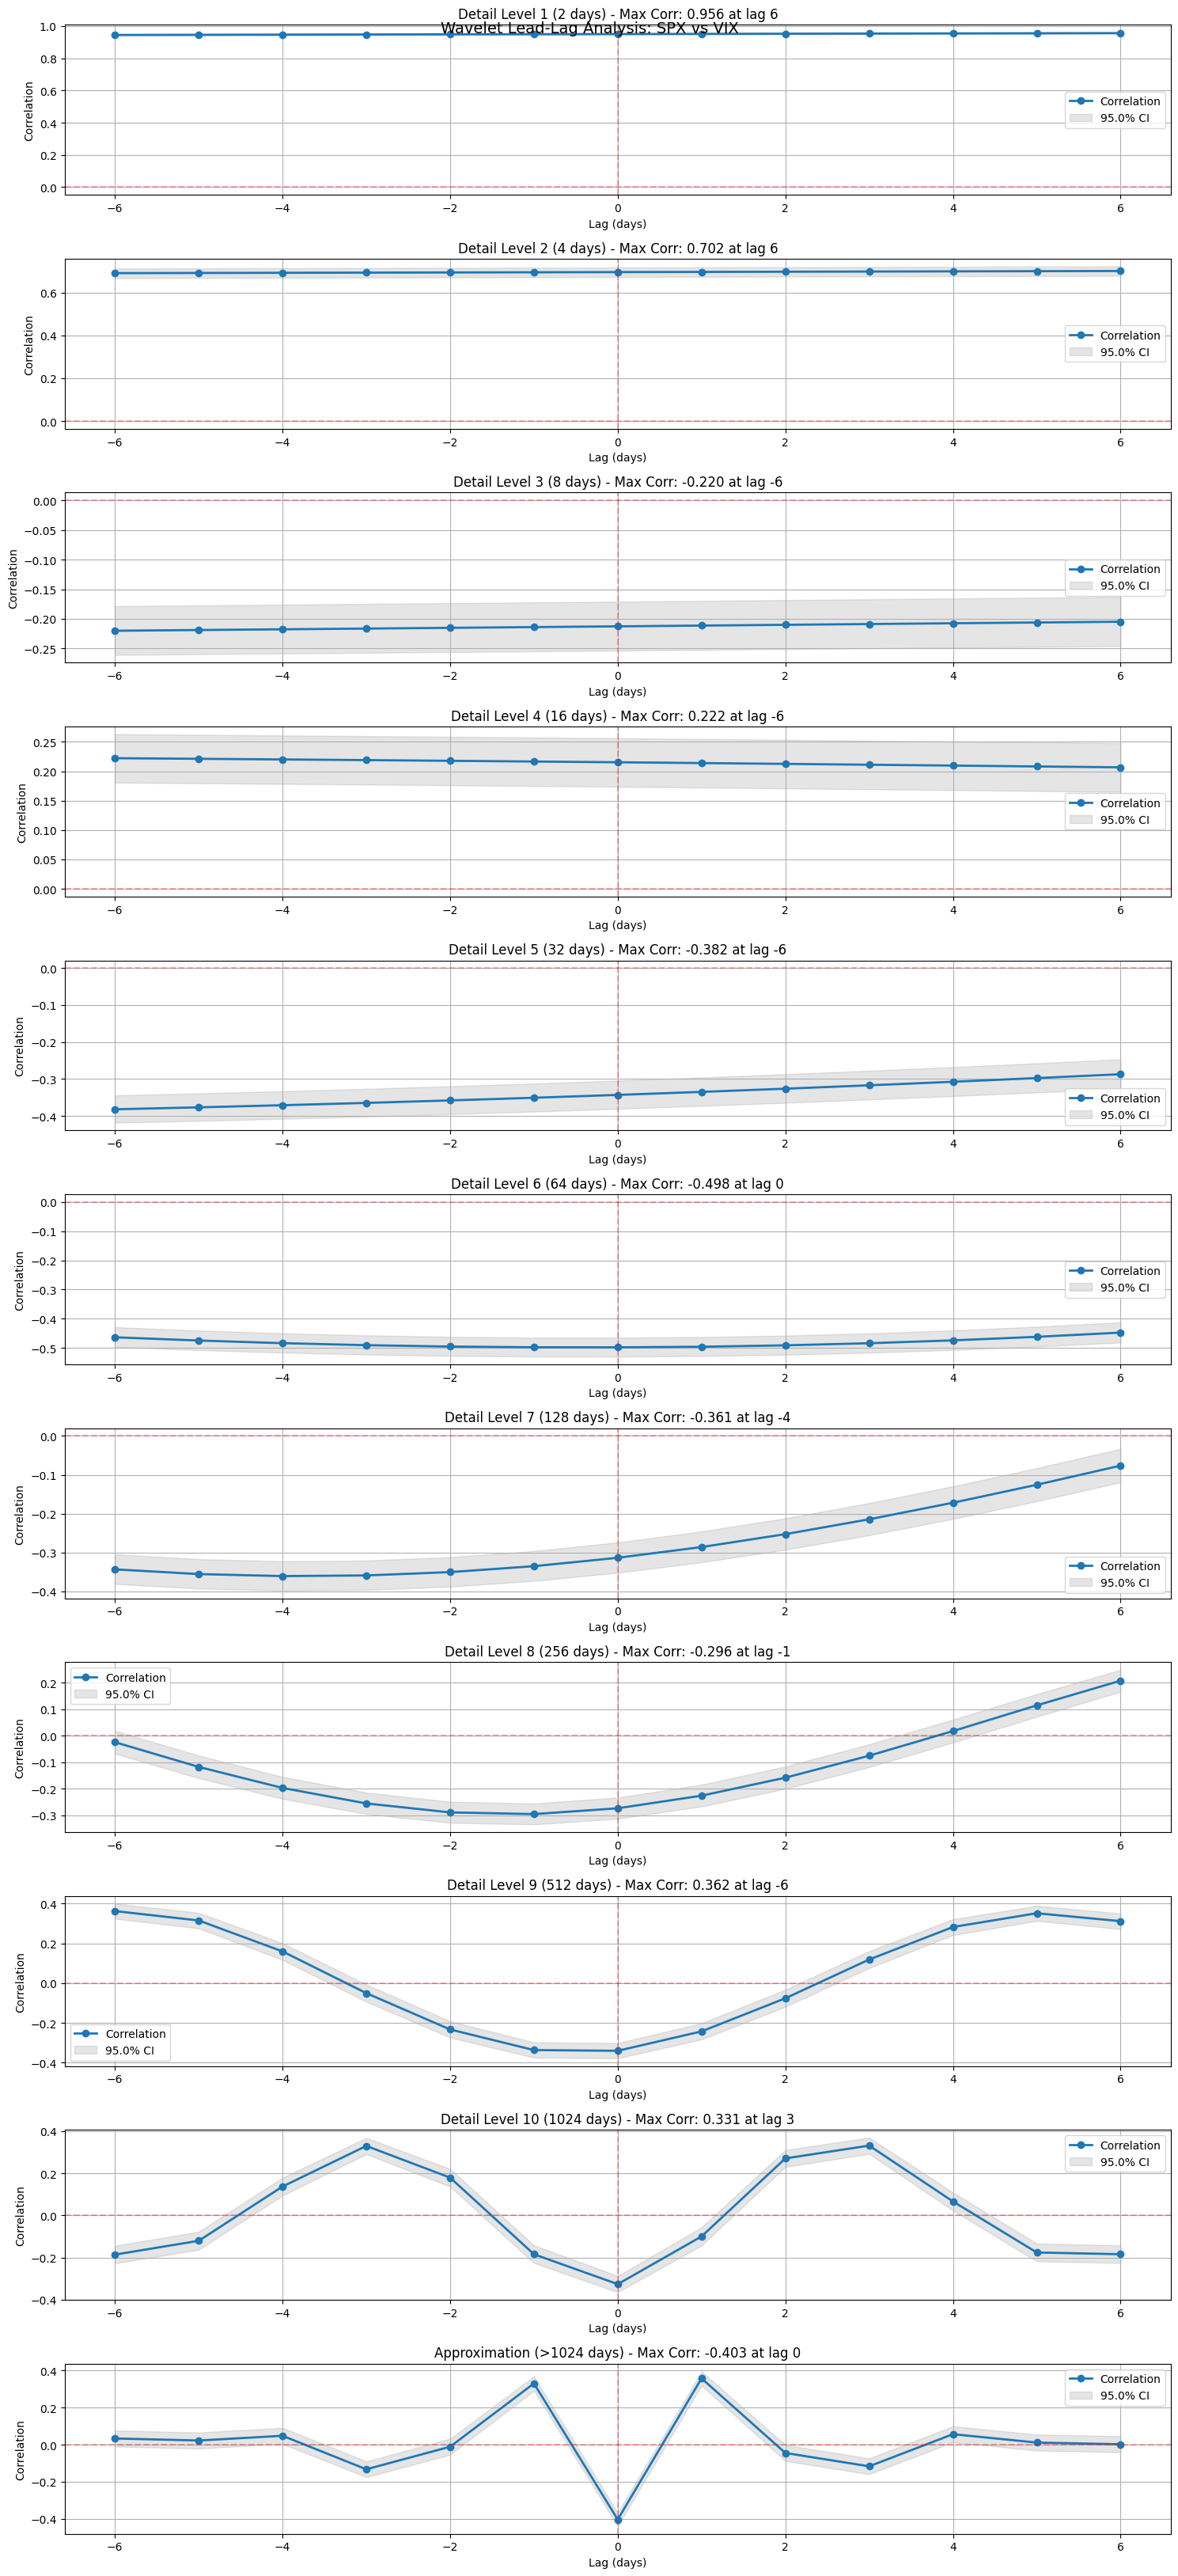


Wavelet Lead-Lag Analysis Summary:

Detail Level 1 (2 days):
Maximum correlation: 0.956 at lag 6
SPX leads VIX

Detail Level 2 (4 days):
Maximum correlation: 0.702 at lag 6
SPX leads VIX

Detail Level 3 (8 days):
Maximum correlation: -0.220 at lag -6
VIX leads SPX

Detail Level 4 (16 days):
Maximum correlation: 0.222 at lag -6
VIX leads SPX

Detail Level 5 (32 days):
Maximum correlation: -0.382 at lag -6
VIX leads SPX

Detail Level 6 (64 days):
Maximum correlation: -0.498 at lag 0
No lead-lag relationship

Detail Level 7 (128 days):
Maximum correlation: -0.361 at lag -4
VIX leads SPX

Detail Level 8 (256 days):
Maximum correlation: -0.296 at lag -1
VIX leads SPX

Detail Level 9 (512 days):
Maximum correlation: 0.362 at lag -6
VIX leads SPX

Detail Level 10 (1024 days):
Maximum correlation: 0.331 at lag 3
SPX leads VIX

Approximation (>1024 days):
Maximum correlation: -0.403 at lag 0
No lead-lag relationship


In [62]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy import stats

def get_market_data(days = 10*365):
    """
    Download VIX and SPX data for the last 10 years
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    # Download data
    spx = yf.download('^GSPC', start=start_date, end=end_date)['Close']
    vix = yf.download('^VIX', start=start_date, end=end_date)['Close']

    # Align the series
    data = pd.DataFrame({
        'SPX':[ np.log(el[0]) for el in spx.values],
        'VIX':[ np.log(el[0]) for el in vix.values]
    }, index=spx.index)

    return data.dropna()

def plot_decomposition(data, coeffs_spx, coeffs_vix, dates, level, wavelet):
    """
    Plot the time series decomposition at each level
    """
    fig, axs = plt.subplots(level + 1, 2, figsize=(15, 4*(level + 1)))
    fig.suptitle(f'Wavelet Decomposition using {wavelet}', fontsize=14)

    # Plot original series
    axs[0, 0].plot(dates, data['SPX'], 'b-', label='SPX')
    axs[0, 0].set_title('Original SPX Series')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    axs[0, 1].plot(dates, data['VIX'], 'r-', label='VIX')
    axs[0, 1].set_title('Original VIX Series')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot decomposition levels
    for i in range(level):
        # SPX decomposition
        axs[i+1, 0].plot(dates, coeffs_spx[i], 'b-')
        axs[i+1, 0].set_title(f'SPX Detail Level {i+1} ({2**(i+1)} days)')
        axs[i+1, 0].grid(True)

        # VIX decomposition
        axs[i+1, 1].plot(dates, coeffs_vix[i], 'r-')
        axs[i+1, 1].set_title(f'VIX Detail Level {i+1} ({2**(i+1)} days)')
        axs[i+1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def compute_lead_lag_correlation(x, y, max_lag):
    """
    Compute lead-lag correlation between two series
    """
    if len(x) < 2 or len(y) < 2:
        return None, None

    correlations = []
    lags = range(-max_lag, max_lag + 1)

    for lag in lags:
        if lag < 0:
            # y leads x
            if len(x[-lag:]) > 1 and len(y[:lag]) > 1:
                corr = np.corrcoef(x[-lag:], y[:lag])[0, 1]
            else:
                corr = np.nan
        elif lag > 0:
            # x leads y
            if len(x[:-lag]) > 1 and len(y[lag:]) > 1:
                corr = np.corrcoef(x[:-lag], y[lag:])[0, 1]
            else:
                corr = np.nan
        else:
            # concurrent correlation
            corr = np.corrcoef(x, y)[0, 1]

        correlations.append(corr)

    return np.array(correlations), np.array(lags)

def plot_correlation_with_ci(correlations, lags, n, level_name, ax):
    """
    Plot correlation with confidence intervals
    """
    # Calculate confidence intervals
    conf_level = 0.95
    z_score = stats.norm.ppf((1 + conf_level) / 2)
    ci_width = z_score / np.sqrt(n-3)

    z_transf = np.arctanh(correlations)
    ci_lower = np.tanh(z_transf - ci_width)
    ci_upper = np.tanh(z_transf + ci_width)

    # Plot correlation and CI
    ax.plot(lags, correlations, 'o-', linewidth=2, label='Correlation')
    ax.fill_between(lags, ci_lower, ci_upper, alpha=0.2, color='gray', label=f'{conf_level*100}% CI')
    ax.grid(True)
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Correlation')
    ax.legend()

    # Find maximum correlation
    max_corr_idx = np.nanargmax(np.abs(correlations))
    max_corr = correlations[max_corr_idx]
    max_lag_ = lags[max_corr_idx]
    ax.set_title(f'{level_name} - Max Corr: {max_corr:.3f} at lag {max_lag_}')

def wavelet_lead_lag_analysis(data, wavelet='db4', level=6, max_lag=4):
    """
    Perform wavelet-based lead-lag analysis with decomposition plots
    """
    # Ensure we have valid level number
    if level == None:
        level = pywt.swt_max_level(len(data))-1

    # Ensure we have enough data
    if len(data) < 2**(level+1):
        raise ValueError(f"Not enough data points for level {level} decomposition")

    # Ensure even length
    if len(data) % 2 != 0:
        data = data[:-1]

    dates = data.index

    # Perform wavelet decomposition
    coeffs_spx = pywt.mra(data['SPX'].values, wavelet, level=level, transform='swt')
    coeffs_vix = pywt.mra(data['VIX'].values, wavelet, level=level, transform='swt')

    #coeffs_spx = pywt.swt(data['SPX'].values, wavelet, level=level, norm=True)
    #coeffs_vix = pywt.swt(data['VIX'].values, wavelet, level=level, norm=True)

    # Plot decomposition
    plot_decomposition(data, coeffs_spx, coeffs_vix, dates, level, wavelet)

    # Compute and plot lead-lag correlations
    lead_lag_correlations = []
    fig, axs = plt.subplots(level + 1, 1, figsize=(15, 3*(level + 1)))
    fig.suptitle('Wavelet Lead-Lag Analysis: SPX vs VIX', fontsize=14)

    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(level + 1):
        correlations, lags = compute_lead_lag_correlation(coeffs_spx[i], coeffs_vix[i], max_lag)

        if correlations is None or np.all(np.isnan(correlations)):
            print(f"Skipping level {i} due to insufficient data")
            continue

        # Remove NaN values
        mask = ~np.isnan(correlations)
        correlations = correlations[mask]
        lags = lags[mask]

        if len(correlations) == 0:
            print(f"No valid correlations at level {i}")
            continue

        lead_lag_correlations.append((correlations, lags))

        # Plot correlation with confidence intervals
        level_name = f'Detail Level {i+1} ({2**(i+1)} days)' if i < level else f'Approximation (>{2**level} days)'
        plot_correlation_with_ci(correlations, lags, len(coeffs_spx[i]), level_name, axs[i])

    plt.tight_layout()
    plt.show()

    return lead_lag_correlations

# Get and prepare data
print("Downloading market data...")
data = get_market_data()
data = data[:2*1024]
print("\nData Summary:")
print("=" * 50)
print(f"Date Range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Number of observations: {len(data)}")

# Perform wavelet lead-lag analysis
print("\nComputing wavelet lead-lag correlations...")
try:
    lead_lag_results = wavelet_lead_lag_analysis(data, wavelet='db6', level=None, max_lag=6)

    # Print detailed analysis
    print("\nWavelet Lead-Lag Analysis Summary:")
    print("=" * 50)
    for i, (corrs, lags) in enumerate(lead_lag_results):
        if len(corrs) > 0:
            max_idx = np.nanargmax(np.abs(corrs))
            max_corr = corrs[max_idx]
            max_lag_ = lags[max_idx]

            if i < len(lead_lag_results) - 1:
                print(f"\nDetail Level {i+1} ({2**(i+1)} days):")
            else:
                print(f"\nApproximation (>{2**i} days):")
            print(f"Maximum correlation: {max_corr:.3f} at lag {max_lag_}")
            if max_lag_ < 0:
                print("VIX leads SPX")
            elif max_lag_ > 0:
                print("SPX leads VIX")
            else:
                print("No lead-lag relationship")
except Exception as e:
    print(f"Error in analysis: {str(e)}")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



Data Summary:
Date Range: 2014-11-17 to 2023-01-05
Number of observations: 2048

Computing wavelet lead-lag correlations...


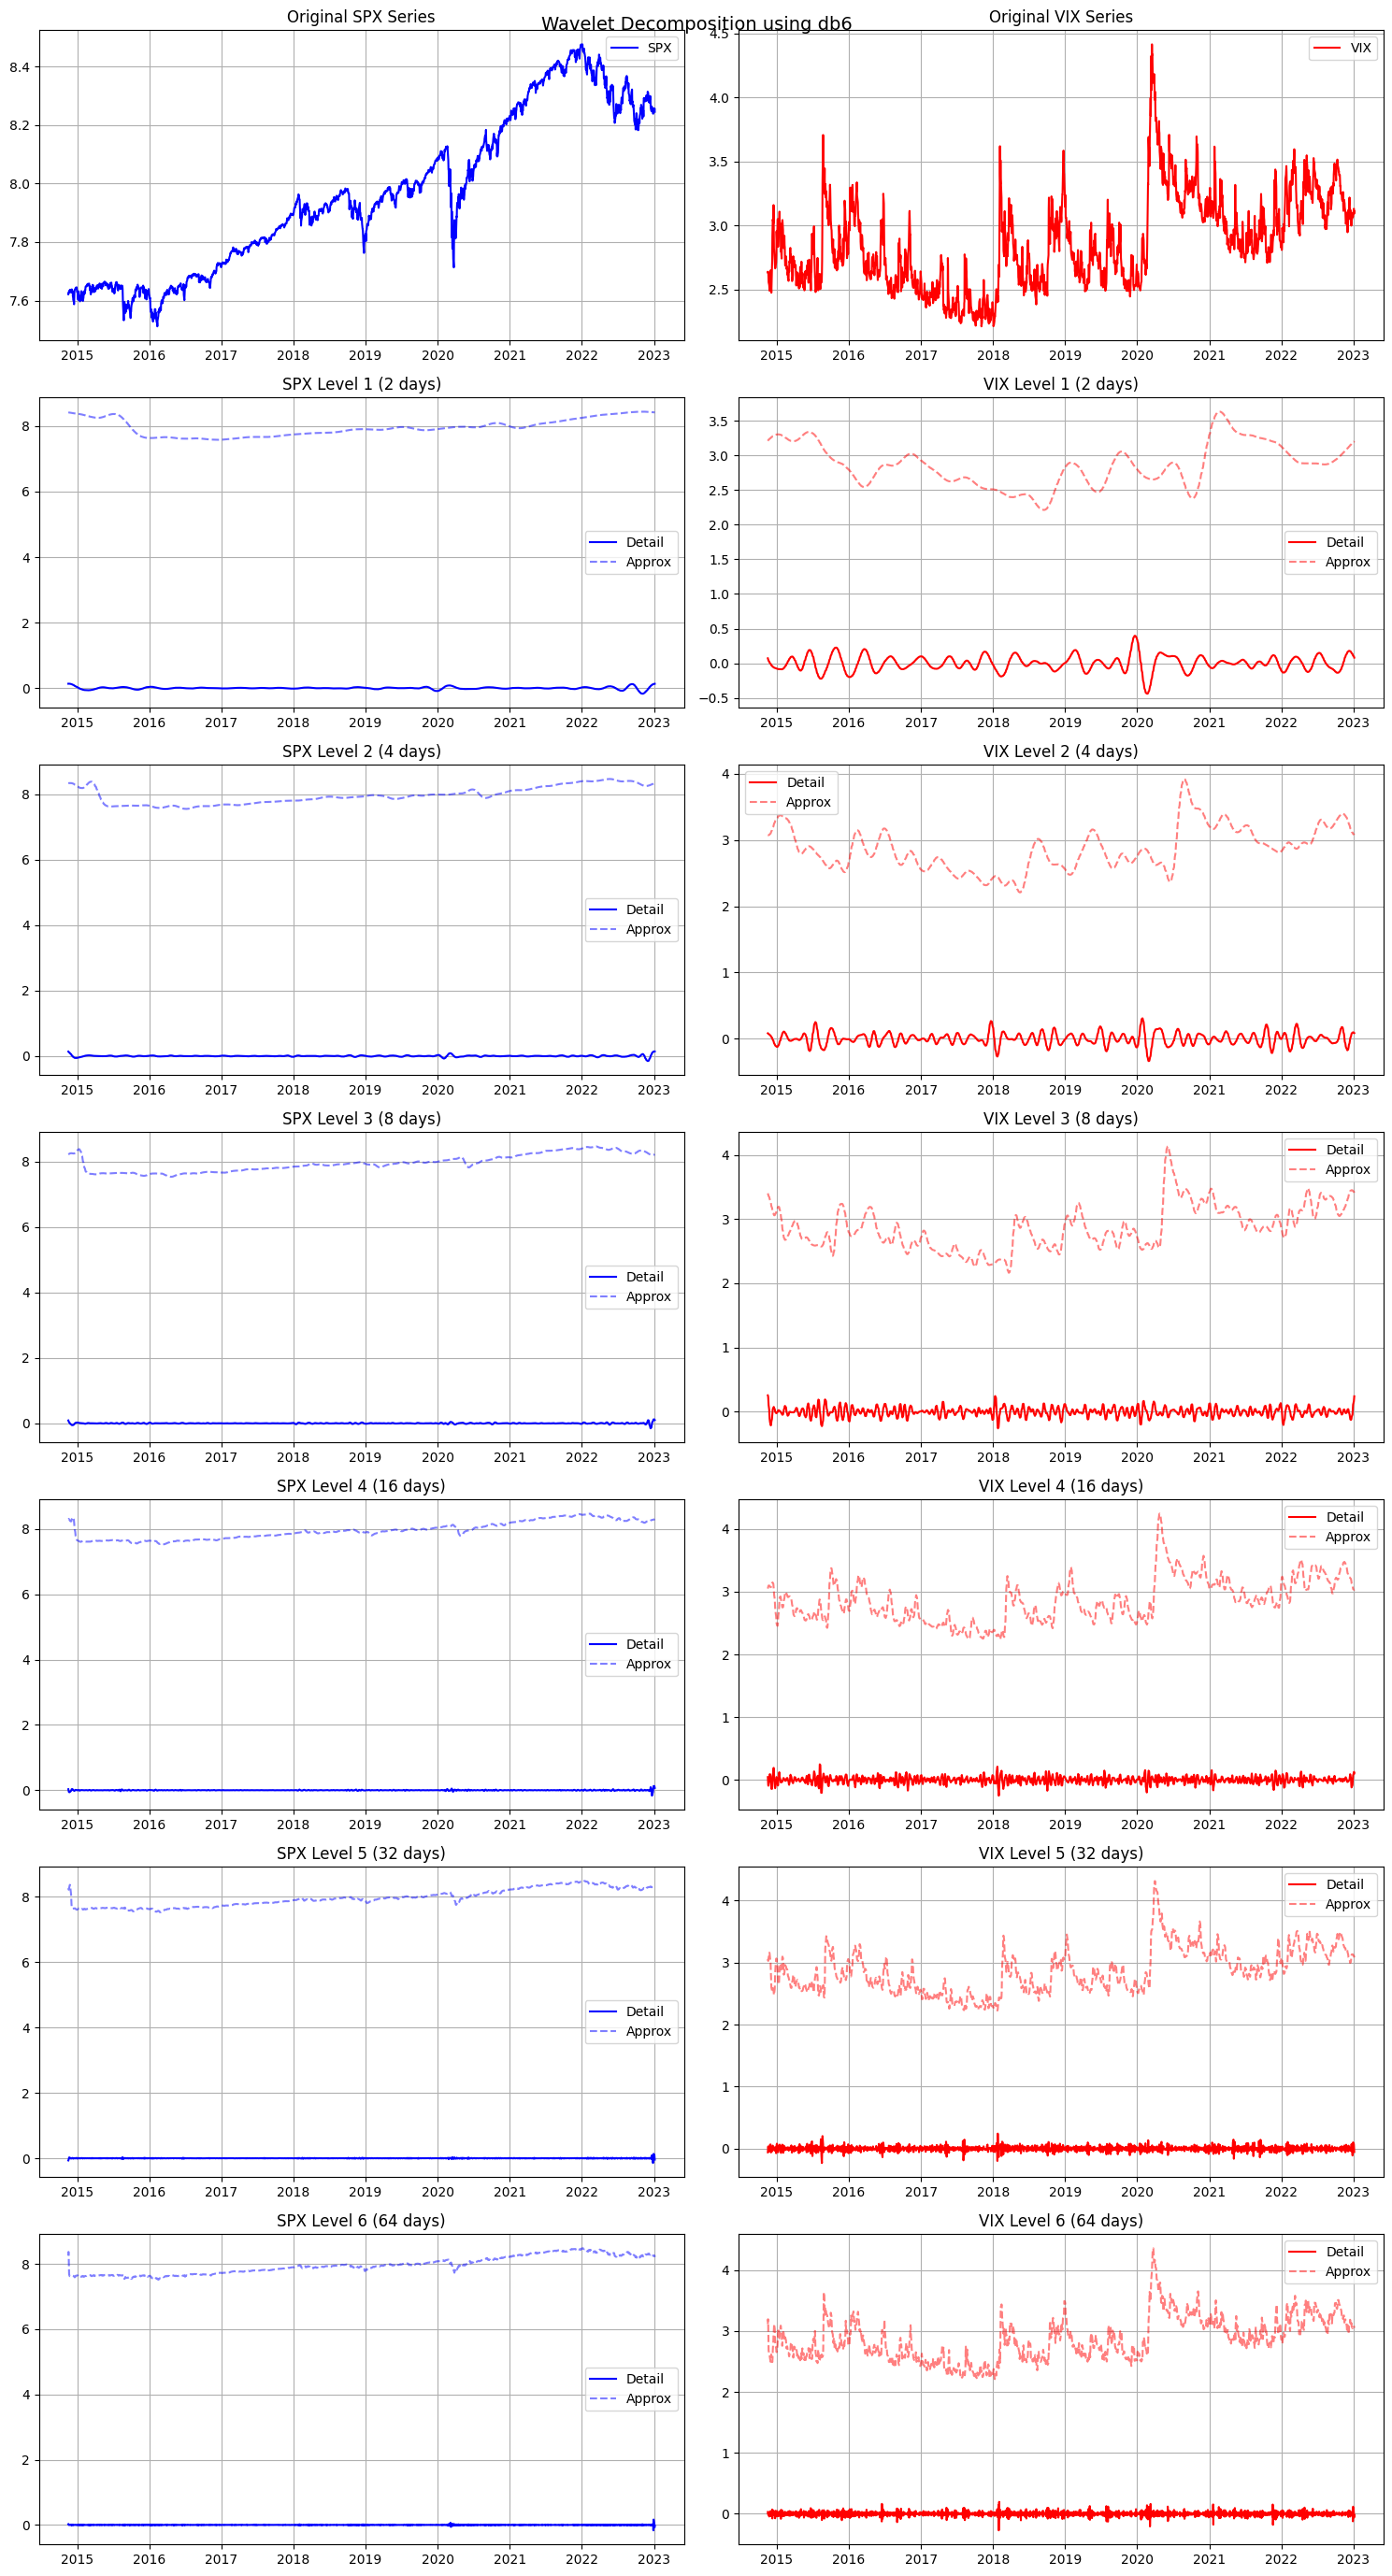

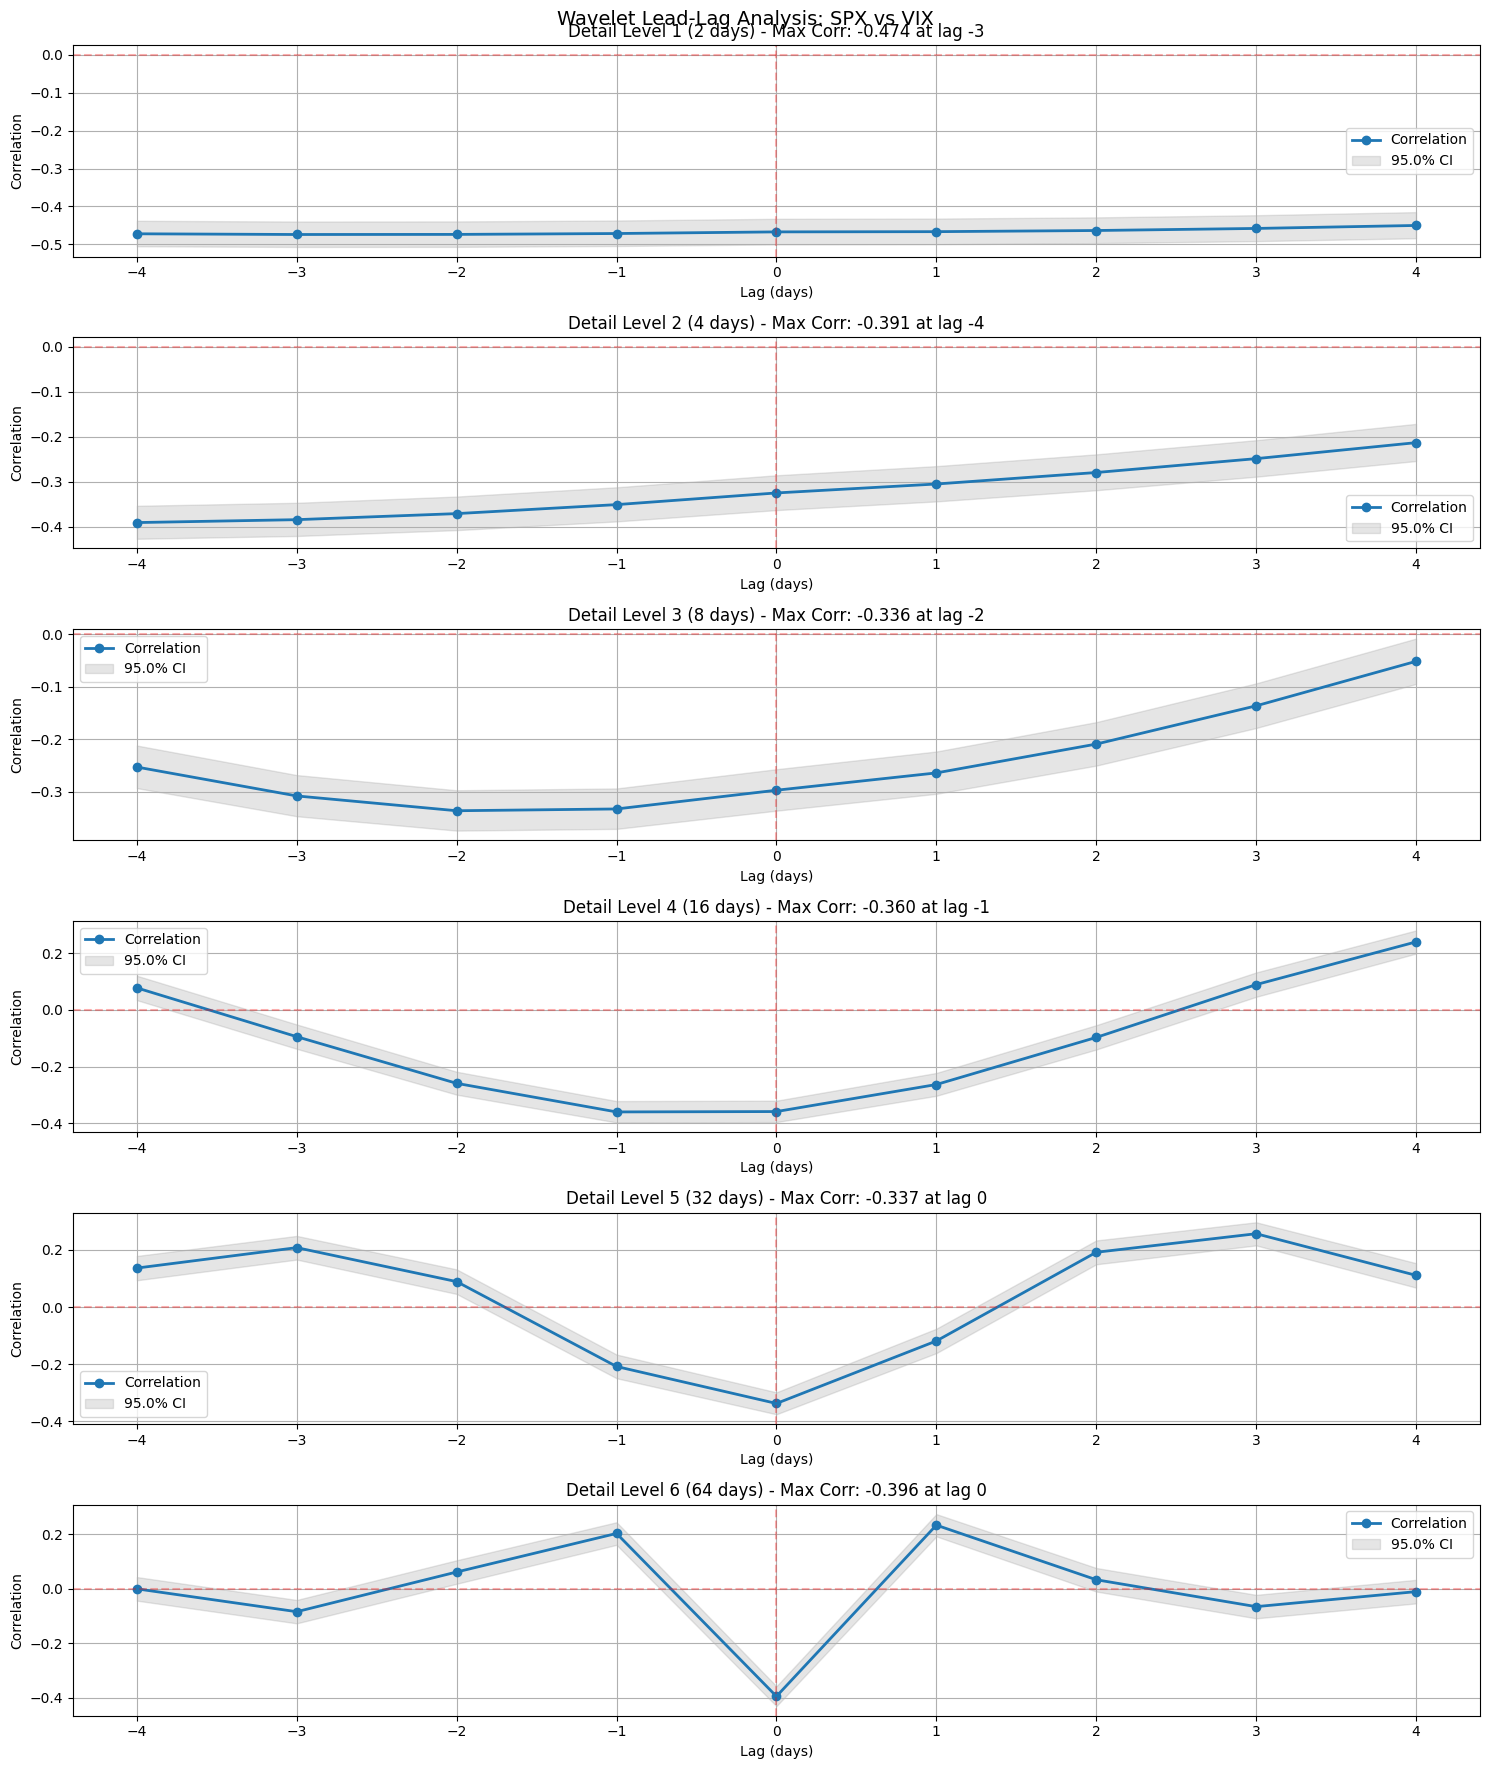

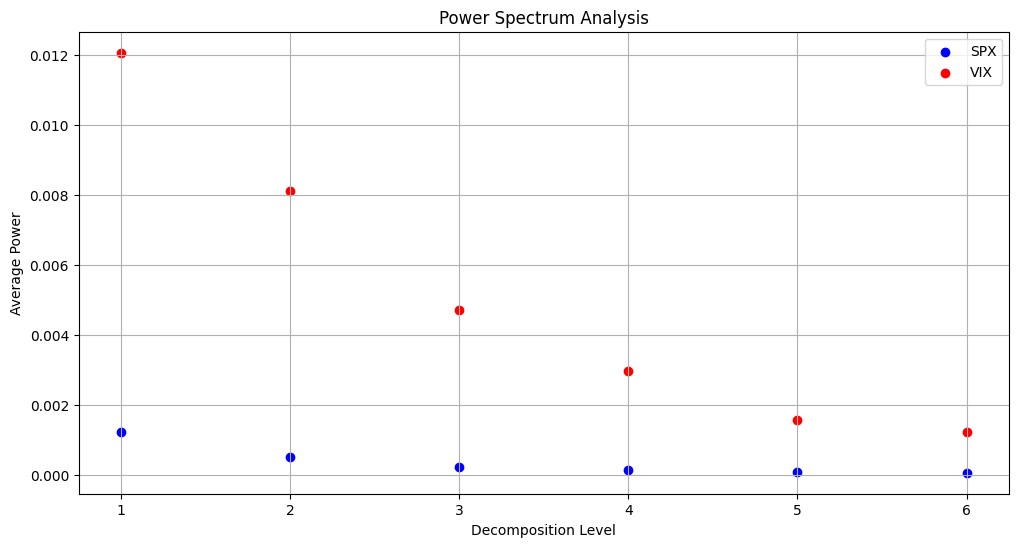


Wavelet Lead-Lag Analysis Summary:

Detail Level 1 (2 days):
Maximum correlation: -0.474 at lag -3
VIX leads SPX

Detail Level 2 (4 days):
Maximum correlation: -0.391 at lag -4
VIX leads SPX

Detail Level 3 (8 days):
Maximum correlation: -0.336 at lag -2
VIX leads SPX

Detail Level 4 (16 days):
Maximum correlation: -0.360 at lag -1
VIX leads SPX

Detail Level 5 (32 days):
Maximum correlation: -0.337 at lag 0
No lead-lag relationship

Approximation (>32 days):
Maximum correlation: -0.396 at lag 0
No lead-lag relationship


In [63]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy import stats

import numpy as np
import pywt
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy import stats

def get_market_data(days = 10*365):
    """
    Download VIX and SPX data for the last 10 years
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    # Download data
    spx = yf.download('^GSPC', start=start_date, end=end_date)['Close']
    vix = yf.download('^VIX', start=start_date, end=end_date)['Close']

    # Align the series
    data = pd.DataFrame({
        'SPX':[ np.log(el[0]) for el in spx.values],
        'VIX':[ np.log(el[0]) for el in vix.values]
    }, index=spx.index)

    return data.dropna()

def plot_decomposition(data, coeffs_spx, coeffs_vix, dates, level, wavelet):
    """
    Plot the time series decomposition at each level using SWT coefficients
    """
    fig, axs = plt.subplots(level + 1, 2, figsize=(15, 4*(level + 1)))
    fig.suptitle(f'Wavelet Decomposition using {wavelet}', fontsize=14)

    # Plot original series
    axs[0, 0].plot(dates, data['SPX'], 'b-', label='SPX')
    axs[0, 0].set_title('Original SPX Series')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    axs[0, 1].plot(dates, data['VIX'], 'r-', label='VIX')
    axs[0, 1].set_title('Original VIX Series')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot decomposition levels
    for i in range(level):
        # SPX decomposition - plot detail coefficients
        axs[i+1, 0].plot(dates, coeffs_spx[i][1], 'b-', label='Detail')
        axs[i+1, 0].plot(dates, coeffs_spx[i][0], 'b--', alpha=0.5, label='Approx')
        axs[i+1, 0].set_title(f'SPX Level {i+1} ({2**(i+1)} days)')
        axs[i+1, 0].grid(True)
        axs[i+1, 0].legend()

        # VIX decomposition - plot detail coefficients
        axs[i+1, 1].plot(dates, coeffs_vix[i][1], 'r-', label='Detail')
        axs[i+1, 1].plot(dates, coeffs_vix[i][0], 'r--', alpha=0.5, label='Approx')
        axs[i+1, 1].set_title(f'VIX Level {i+1} ({2**(i+1)} days)')
        axs[i+1, 1].grid(True)
        axs[i+1, 1].legend()

    plt.tight_layout()
    plt.show()

def wavelet_lead_lag_analysis(data, wavelet='db4', level=6, max_lag=4):
    """
    Perform wavelet-based lead-lag analysis with decomposition plots using SWT
    """
    # Ensure we have valid level number
    if level == None:
        level = pywt.swt_max_level(len(data))

    # Ensure we have enough data
    if len(data) < 2**(level+1):
        raise ValueError(f"Not enough data points for level {level} decomposition")

    # Ensure even length
    if len(data) % 2 != 0:
        data = data[:-1]

    dates = data.index

    # Perform stationary wavelet transform
    coeffs_spx = pywt.swt(data['SPX'].values, wavelet, level=level, norm=True)
    coeffs_vix = pywt.swt(data['VIX'].values, wavelet, level=level, norm=True)

    # Plot decomposition
    plot_decomposition(data, coeffs_spx, coeffs_vix, dates, level, wavelet)

    # Compute and plot lead-lag correlations
    lead_lag_correlations = []
    fig, axs = plt.subplots(level, 1, figsize=(15, 3*level))
    fig.suptitle('Wavelet Lead-Lag Analysis: SPX vs VIX', fontsize=14)

    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(level):
        # Use detail coefficients (index 1) for correlation analysis
        correlations, lags = compute_lead_lag_correlation(coeffs_spx[i][1], coeffs_vix[i][1], max_lag)

        if correlations is None or np.all(np.isnan(correlations)):
            print(f"Skipping level {i} due to insufficient data")
            continue

        # Remove NaN values
        mask = ~np.isnan(correlations)
        correlations = correlations[mask]
        lags = lags[mask]

        if len(correlations) == 0:
            print(f"No valid correlations at level {i}")
            continue

        lead_lag_correlations.append((correlations, lags))

        # Plot correlation with confidence intervals
        level_name = f'Detail Level {i+1} ({2**(i+1)} days)'
        plot_correlation_with_ci(correlations, lags, len(coeffs_spx[i][1]), level_name, axs[i])

    plt.tight_layout()
    plt.show()

    # Additional plot: Power spectrum at each level
    plt.figure(figsize=(12, 6))
    for i in range(level):
        power_spx = np.mean(coeffs_spx[i][1]**2)
        power_vix = np.mean(coeffs_vix[i][1]**2)
        plt.scatter(i+1, power_spx, c='blue', label='SPX' if i==0 else "")
        plt.scatter(i+1, power_vix, c='red', label='VIX' if i==0 else "")

    plt.xlabel('Decomposition Level')
    plt.ylabel('Average Power')
    plt.title('Power Spectrum Analysis')
    plt.grid(True)
    plt.legend()
    plt.show()

    return lead_lag_correlations

# Get and prepare data
print("Downloading market data...")
data = get_market_data()
data = data[:2*1024]
print("\nData Summary:")
print("=" * 50)
print(f"Date Range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Number of observations: {len(data)}")

# Perform wavelet lead-lag analysis
print("\nComputing wavelet lead-lag correlations...")
try:
    lead_lag_results = wavelet_lead_lag_analysis(data, wavelet='db6', level=6, max_lag=4)

    # Print detailed analysis
    print("\nWavelet Lead-Lag Analysis Summary:")
    print("=" * 50)
    for i, (corrs, lags) in enumerate(lead_lag_results):
        if len(corrs) > 0:
            max_idx = np.nanargmax(np.abs(corrs))
            max_corr = corrs[max_idx]
            max_lag_ = lags[max_idx]

            if i < len(lead_lag_results) - 1:
                print(f"\nDetail Level {i+1} ({2**(i+1)} days):")
            else:
                print(f"\nApproximation (>{2**i} days):")
            print(f"Maximum correlation: {max_corr:.3f} at lag {max_lag_}")
            if max_lag_ < 0:
                print("VIX leads SPX")
            elif max_lag_ > 0:
                print("SPX leads VIX")
            else:
                print("No lead-lag relationship")
except Exception as e:
    print(f"Error in analysis: {str(e)}")